In [3]:
from matplotlib.colors import ListedColormap
from sklearn import datasets, metrics, neighbors 
import sklearn.model_selection as ms
import scipy.stats as sts

import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Генерация данных

In [113]:
def generate_sample(x, size=1):
    return 0.5 * x + 1 + sts.norm.rvs(loc=0, scale=np.sqrt(0.2), size=size)

In [122]:
X = sts.uniform.rvs(loc=-10000, scale=20000, size=500)
Y = generate_sample(X)

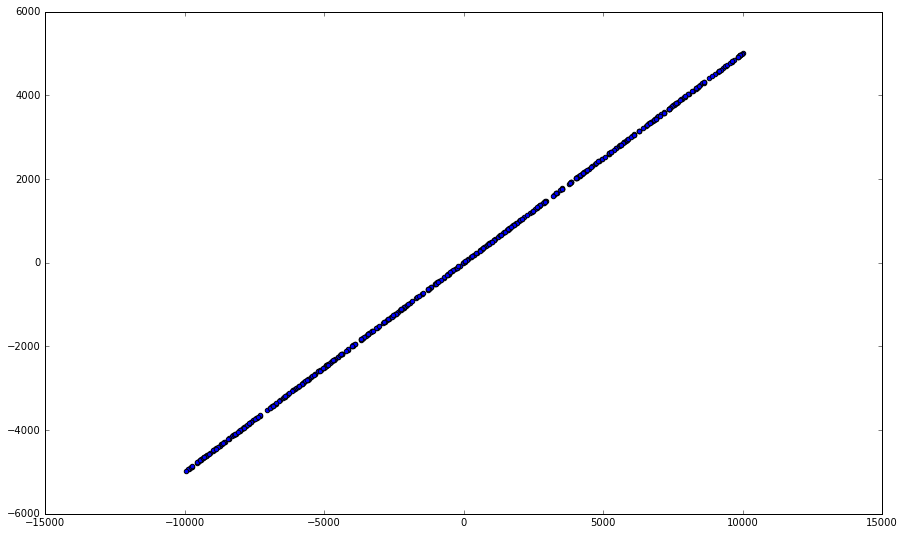

In [123]:
plt.figure(figsize=(15,9))
plt.scatter(X, Y)

In [124]:
train_data, test_data, train_target, test_target = ms.train_test_split(X, Y, test_size=0.4, random_state=1)

In [125]:
import scipy.optimize as opt

Оценим параметры $k, b$ с помощью минимизации MSE = $\frac{1}{n} \sum_{i=1}^{n} (\hat{y_i} - y_i)^2$

In [127]:
x = train_data
target = train_target
def MSE((k, b)):
    n = float(len(target))
    return 1/n * np.sum((k * x + b - target) ** 2)

In [134]:
res = opt.minimize(MSE, (1, 1), method='Nelder-Mead', tol=1e-12)
k, b = res.x

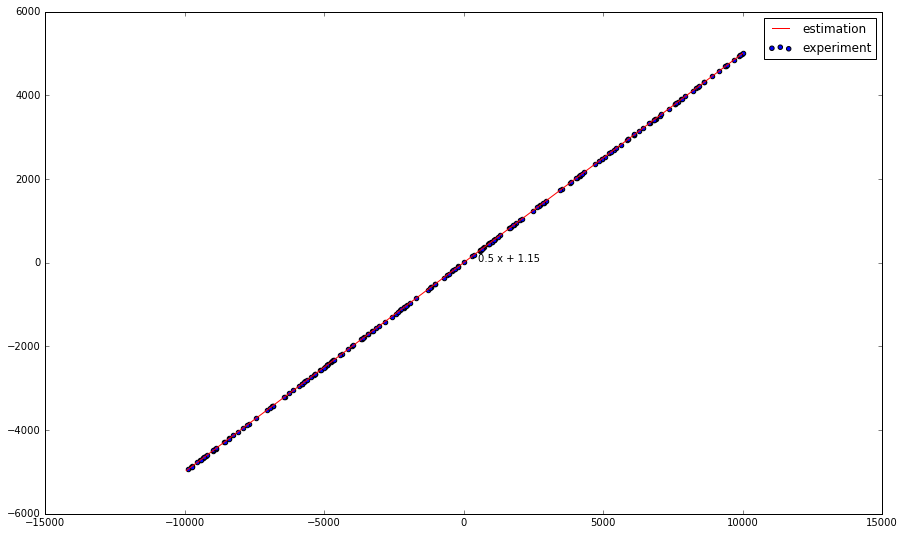

In [135]:
p = np.array([np.min(X), np.max(X)])
plt.figure(figsize=(15,9))
plt.plot(p, k * p + b, label='estimation', color='red')
plt.scatter(test_data, test_target, label='experiment')
plt.text(500, 30, s='%0.1f x + %0.2f' %(k, b))
plt.legend(loc='best')

Если провести серию оценок, то окажется, что MSE плохо оценивает $b$, но отлично 'чувствует' $k$

In [171]:
estimations = []
for i in range(100):
    X = sts.uniform.rvs(loc=-10000, scale=20000, size=500)
    Y = generate_sample(X)

    train_data, test_data, train_target, test_target = ms.train_test_split(X, Y, test_size=0.2, random_state=1)
    x = train_data
    target = train_target

    def MSE((k, b)):
        n = float(len(target))
        return 1/n * np.sum((k * x + b - target) ** 2)

    res = opt.minimize(MSE, (1, 1), method='Nelder-Mead', tol=1e-12)
    estimations.append(res.x)

Оценки $k$

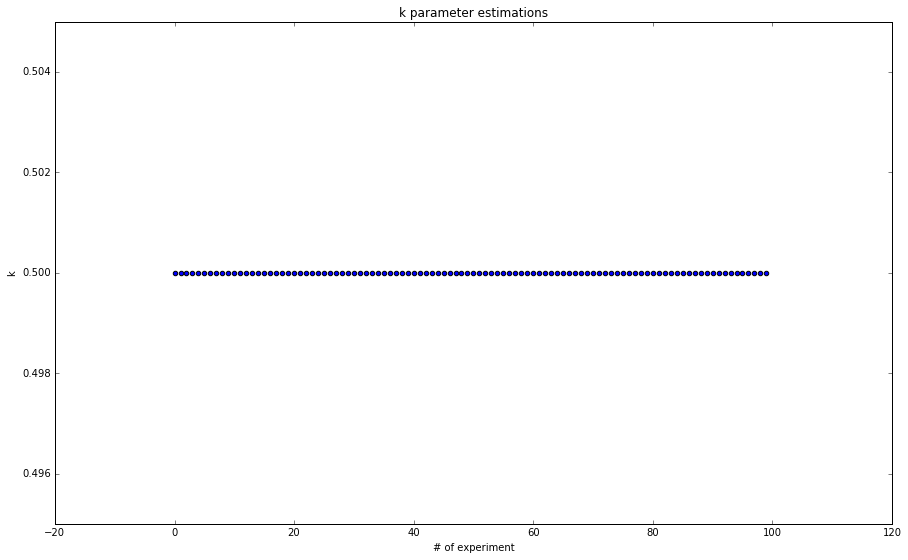

In [183]:
plt.figure(figsize=(15,9))
plt.title(u'k parameter estimations')
plt.xlabel('# of experiment')
plt.ylabel('k')
plt.scatter(np.arange(len(estimations)), map(lambda x: x[0], estimations))

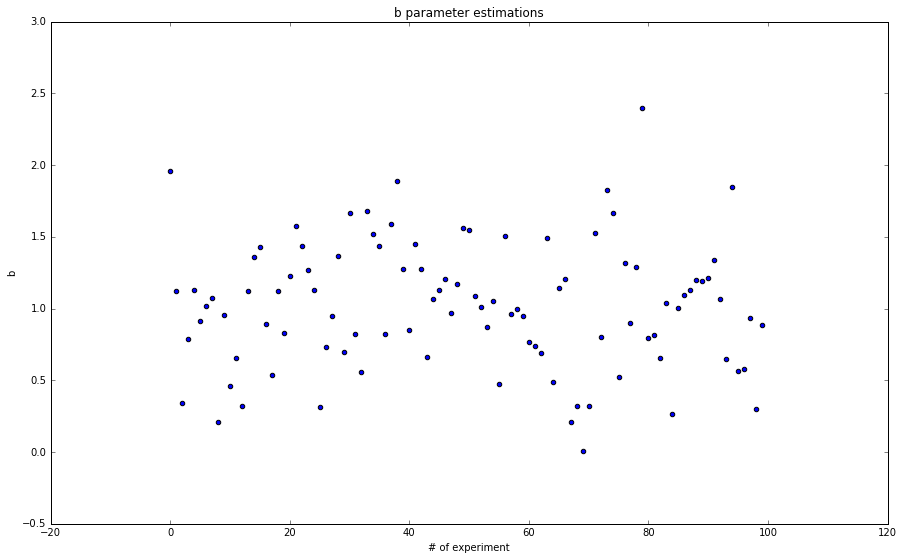

In [182]:
plt.figure(figsize=(15,9))
plt.xlabel('# of experiment')
plt.ylabel('b')
plt.title(u'b parameter estimations')
plt.scatter(np.arange(len(estimations)), map(lambda x: x[1], estimations))

Однако, усредняя оценки мы получаем, что $b=1$

In [184]:
np.average(map(lambda x: x[1], estimations))

1.02167339882856

# Устройчивость к выбросам

Проверим устойчивость к выбросам оценок через MSE и MAE

In [211]:
def generate_sample_with_extra_noise(x):
    noise = sts.norm.rvs(loc=0, scale=np.sqrt(0.2), size=75) - 1
    real_data = 0.5 * x + 1 + sts.norm.rvs(loc=0, scale=np.sqrt(0.2), size=500) 
    return np.append(real_data, noise)

In [220]:
X = sts.uniform.rvs(loc=-10000, scale=20000, size=500)
Y_with_noise = generate_sample_with_extra_noise(X)
X_with_noise = np.append(X, sts.uniform.rvs(loc=-10000, scale=20000, size=75))
train_data, test_data, train_target, test_target = ms.train_test_split(X_with_noise, Y_with_noise, test_size=0.4, random_state=1)
x = train_data
target = train_target

In [225]:
def MSE((k, b)):
    n = float(len(target))
    return 1/n * np.sum((k * x + b - target) ** 2)

In [241]:
def MAE((k, b)):
    n = float(len(target))
    return 1/n * np.sum(np.abs(k * x + b - target))

In [242]:
res = opt.minimize(MSE, (1, 1), method='Nelder-Mead', tol=1e-12)
k_mse, b_mse = res.x

In [243]:
res = opt.minimize(MAE, (1, 1), method='Nelder-Mead', tol=1e-12)
k_mae, b_mae = res.x

In [244]:
res = opt.minimize(ME10, (1, 1), method='Nelder-Mead', tol=1e-12)
k_me10, b_me10 = res.x

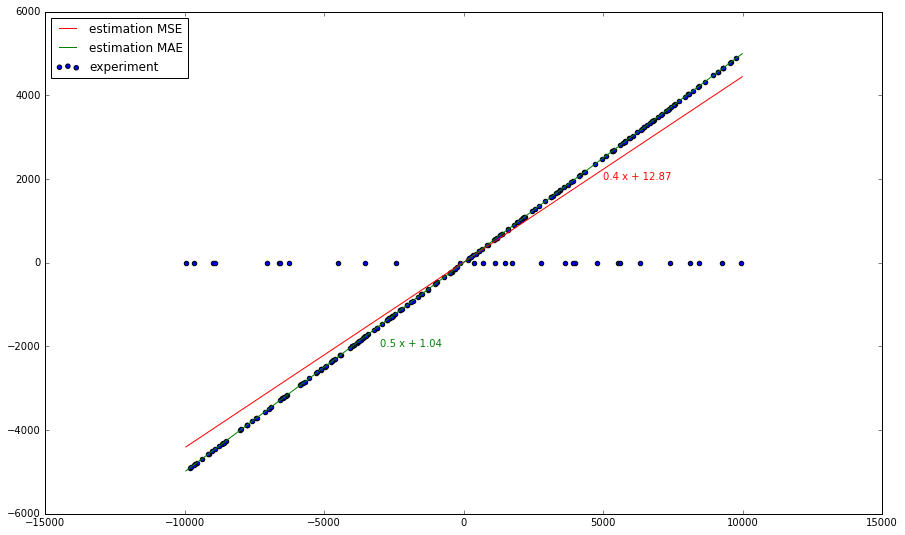

In [245]:
p = np.array([np.min(X), np.max(X)])
plt.figure(figsize=(15,9))
plt.plot(p, k_mse * p + b_mse, label='estimation MSE', color='red')
plt.plot(p, k_mae * p + b_mae, label='estimation MAE', color='green')
plt.scatter(test_data, test_target, label='experiment')
plt.text(5000, 2000, s='%0.1f x + %0.2f' %(k_mse, b_mse), color='red')
plt.text(-3000, -2000, s='%0.1f x + %0.2f' %(k_mae, b_mae), color='green')
plt.legend(loc='best')

Коэффиценты у MSE сильно изменились, в то время, как у MAE осталась хорошая оценка параметров.
Как видим, MAE устойчиво к выбросам, в то время как MSE делает поправку. Происходит это из-за особенности 1-метрики Минковского: часть признаков из данных (здесь -- это шумовой вброс) становятся менее значимы.